In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang")

In [3]:
import torch

from ebb.env.luxenv import get_ob_sapce
from ebb.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-5,
        reward_max=+5,
        zero_sum=False,
    )

reward_shaping_params = dict(  new_observed_down_tri=0.0001,
  match_observed=0,
  match_win=1,
  use_hidden_relic_estimator=True,
  energy_cost_change=0.001,                             
)

obs_space_kwargs = {
    'use_energy_cost_map': True,
    'use_single_player': False,
    "use_agent": False,
}

# Load model

In [4]:
# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_2025026_imitation_r0/011321856_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250207_behaviour_cloning_test_run_v4/000161856_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250208_behaviour_cloning_r0_with_drift_estimation_cont3/027721664_weights.pt"

model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250210_post_training_full_kl_and_entropy_r0/028716800_weights.pt"


ob_space = get_ob_sapce(obs_space_kwargs)
model = _create_model(ob_space, reward_spec=reward_spec, n_blocks=8, hidden_dim=128, base_out_channels=128,
                      embedding_dim=16, kernel_size=5)


checkpoint_state = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(checkpoint_state["model_state_dict"])

<All keys matched successfully>

# Model Run

In [5]:
from luxai_s3.params import EnvParams

from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode
from ebb.env.luxenv import LuxS3Env
from ebb.env.wrappers import VecEnv, PytorchEnv, DictEnv
from ebb.torchbeast.core.selfplay import split_env_output_by_player, pair_env_output_for_players


def actor_model_apply(env_output, sample=True):
  lef_env_out, rig_env_out = split_env_output_by_player(env_output)
  lef_agent_out = actor_model(lef_env_out, sample=sample)
  rig_agent_out = actor_model(rig_env_out, sample=sample)
  return [(lef_env_out, lef_agent_out), (rig_env_out, rig_agent_out)]

def get_merged_actions(env_agent_out):
  lef_actions = env_agent_out[0][1]['actions']
  rig_actions = env_agent_out[1][1]['actions']
  return pair_env_output_for_players(lef_actions, rig_actions)

class AgentStats:

    def __init__(self):
        self.baseline = []


    def add_baseline(self, b):
        self.baseline.append(float(b.detach().numpy()))

        

In [8]:
game_env = LuxAIS3GymEnv(numpy_output=True)
game_env = RecordEpisode(game_env, save_dir="episodes1")

lux_env = LuxS3Env('match_explore_win_loss', 
                   obs_space_kwargs,
                   game_env,
                   reward_shaping_params=reward_shaping_params)
env = VecEnv([lux_env])
env = PytorchEnv(env, torch.device('cpu'))
env = DictEnv(env)

actor_model = model

# env_output = env.reset(force=True, seed=1331520750)
env_output = env.reset(force=True)

a1_stats = AgentStats()
a2_stats = AgentStats()


use_single_player = obs_space_kwargs['use_single_player']

while True:
    env_agent_output = actor_model_apply(env_output)
    a1_stats.add_baseline(env_agent_output[0][1]['baseline'][0][0])
    a2_stats.add_baseline(env_agent_output[1][1]['baseline'][0][0])

    actions = get_merged_actions(env_agent_output)
    env_output = env.step(actions)
    if env_output["done"].any():
        break

game_env.close()

lux_env._seed

step=1 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=1] comm_visible.sum() = 0
***** --> found energy node at [7 8]
step=0 (after update), energy field found=True, node=[7 8], candidates=[array([7, 8])]
--> using energy node at [7 8]
[debug][step=1] comm_visible.sum() = 0
***** --> found energy node at [7 8]
step=0 (after update), energy field found=True, node=[7 8], candidates=[array([7, 8])]
--> using energy node at [7 8]
[debug][step=2] comm_visible.sum() = 3


step=2 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


***** --> found energy node at [ 8 10]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=2] comm_visible.sum() = 3
***** --> found energy node at [ 8 10]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=3] comm_visible.sum() = 5
step=2 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=3, mstep=3, nebula_energy_reduction=25
 [debug] unit=0, [1 0]=>[2 0] e=(93=63) a=2
[debug][step=3] comm_visible.sum() = 5
step=2 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]


step=3 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=4 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=5 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=6 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=4] comm_visible.sum() = 6
step=3 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=4, mstep=4, nebula_energy_reduction=25
 [debug] unit=0, [2 0]=>[3 0] e=(63=36) a=2
[debug][step=4] comm_visible.sum() = 7
step=3 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=4, mstep=4, nebula_energy_reduction=25
 [debug] unit=0, [22 22]=>[22 21] e=(89=63) a=1
[debug][step=5] comm_visible.sum() = 11
step=4 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=5, mstep=5, nebula_energy_reduction=25
 [debug] unit=0, [3 0]=>[4 0] e=(36=12) a=2
[debug][step=5] comm_visible.sum() = 10
step=4 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=5, mstep=5, nebula_energy_reduction=25
 [debug] unit=0, [22 21]=>[22 

step=7 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=8 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=9 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=10 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=8, apply nebula drift = 0.15, Counter({0.15: 2, -0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
[debug][step=8] comm_visible.sum() = 26
step=7 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=8, apply nebula drift = 0.15, Counter({0.15: 2, -0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
[debug][step=8] comm_visible.sum() = 27
step=7 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=8, mstep=8, nebula_energy_reduction=25
 [debug] unit=0, [22 18]=>[22 18] e=(15=20) a=0
[debug][step=9] comm_visible.sum() = 29
step=8 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=9] comm_visible.sum() = 27
step=8 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy n

step=11 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=12 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=13 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=14 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=12] comm_visible.sum() = 49
step=11 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=12] comm_visible.sum() = 48
step=11 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=13] comm_visible.sum() = 53
step=12 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=13] comm_visible.sum() = 53
step=12 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=14] comm_visible.sum() = 58
step=13 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=14, mstep=14, nebula_energy_reduction=25
 [debug] unit=4, [0 0]=>[0 1] e=(100=69) a=3
[debug][step=14] comm_visible.sum() = 57
step=13 (after update), energy field 

step=15 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=16 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=17 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=18 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=16] comm_visible.sum() = 66
step=15 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=16] comm_visible.sum() = 66
step=15 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=17] comm_visible.sum() = 76
step=16 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=17] comm_visible.sum() = 77
step=16 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=18] comm_visible.sum() = 79
step=17 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=18] comm_visible.sum() = 77
step=17 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[deb

step=19 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=20 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=21 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=22 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=20] comm_visible.sum() = 91
step=19 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=20] comm_visible.sum() = 85
step=19 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=21, apply nebula drift = 0.15, Counter({0.15: 4, -0.15: -2, 0.05: -198, 0.1: -198, -0.1: -200, -0.05: -200, -0.025: -299, 0.025: -299})
[debug][step=21] comm_visible.sum() = 97
step=20 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=21, apply nebula drift = 0.15, Counter({0.15: 4, -0.15: -2, 0.05: -198, 0.1: -198, -0.1: -200, -0.05: -200, -0.025: -299, 0.025: -299})
[debug][step=21] comm_visible.sum() = 84
step=20 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=22] comm_visible.sum() = 93
step=21 (afte

step=23 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=24 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=23] comm_visible.sum() = 108
step=22 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=23] comm_visible.sum() = 94
step=22 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=24] comm_visible.sum() = 113
step=23 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=24] comm_visible.sum() = 99
step=23 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]


step=25 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=26 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=27 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=28 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=25] comm_visible.sum() = 113
step=24 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=25] comm_visible.sum() = 102
step=24 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=26] comm_visible.sum() = 106
step=25 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=26] comm_visible.sum() = 104
step=25 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=27] comm_visible.sum() = 110
step=26 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=27] comm_visible.sum() = 109
step=26 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=29 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=30 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=31 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=32 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=33 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=29] comm_visible.sum() = 132
step=28 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=29] comm_visible.sum() = 109
step=28 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=30] comm_visible.sum() = 133
step=29 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=30] comm_visible.sum() = 117
step=29 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=31] comm_visible.sum() = 131
step=30 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=31] comm_visible.sum() = 122
step=30 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=34 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=35 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=36 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=37 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=37] comm_visible.sum() = 142
step=36 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=37] comm_visible.sum() = 120
step=36 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=38] comm_visible.sum() = 145
step=37 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=38] comm_visible.sum() = 134
step=37 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=39] comm_visible.sum() = 145
step=38 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=39] comm_visible.sum() = 140
step=38 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=38 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=39 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=40 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=41 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=41, apply nebula drift = 0.15, Counter({0.15: 7, -0.15: -5, 0.05: -397, 0.1: -397, -0.1: -401, -0.05: -401, 0.025: -498, -0.025: -500})
[debug][step=41] comm_visible.sum() = 140
step=40 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=41, mstep=41, nebula_energy_reduction=25
 [debug] unit=1, [ 3 13]=>[ 3 13] e=(51=59) a=0
step=41, apply nebula drift = 0.15, Counter({0.15: 7, -0.15: -5, 0.05: -397, 0.1: -397, -0.1: -401, -0.05: -401, 0.025: -498, -0.025: -500})
[debug][step=41] comm_visible.sum() = 161
step=40 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=42] comm_visible.sum() = 139
step=41 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=42] comm_visible.sum() = 164
step=41 (after update), energy field found=True, node=[ 8 10], candidates=[array

step=42 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=43 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=44 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=45 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=45] comm_visible.sum() = 141
step=44 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=45] comm_visible.sum() = 160
step=44 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=46] comm_visible.sum() = 142
step=45 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=46] comm_visible.sum() = 165
step=45 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=47] comm_visible.sum() = 143
step=46 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=47] comm_visible.sum() = 173
step=46 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=46 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=47 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=48 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=49 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=49] comm_visible.sum() = 145
step=48 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=49] comm_visible.sum() = 151
step=48 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=50] comm_visible.sum() = 154
step=49 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=50] comm_visible.sum() = 153
step=49 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=51] comm_visible.sum() = 166
step=50 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=51] comm_visible.sum() = 160
step=50 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=50 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=51 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=52 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=53 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=53] comm_visible.sum() = 173
step=52 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=53] comm_visible.sum() = 159
step=52 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=54] comm_visible.sum() = 175
step=53 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=54] comm_visible.sum() = 162
step=53 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=55, apply nebula drift = 0.15, Counter({0.15: 9, -0.15: -7, 0.05: -597, 0.1: -597, -0.1: -601, -0.05: -601, 0.025: -698, -0.025: -700})
[debug][step=55] comm_visible.sum() = 175
step=54 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=55, apply nebula dr

step=54 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=55 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=56 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=57 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=58 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=57] comm_visible.sum() = 176
step=56 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=58] comm_visible.sum() = 170
step=57 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=58] comm_visible.sum() = 177
step=57 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=59] comm_visible.sum() = 172
step=58 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=59] comm_visible.sum() = 179
step=58 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=60] comm_visible.sum() = 169
step=59 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=59 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=60 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=61 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=62 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=61, apply nebula drift = 0.15, Counter({0.15: 10, -0.15: -8, 0.05: -596, 0.1: -596, -0.1: -602, -0.05: -602, 0.025: -798, -0.025: -800})
[debug][step=61] comm_visible.sum() = 172
step=60 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=61, mstep=61, nebula_energy_reduction=25
 [debug] unit=15, [3 3]=>[3 4] e=(131=124) a=3
step=61, apply nebula drift = 0.15, Counter({0.15: 10, -0.15: -8, 0.05: -596, 0.1: -596, -0.1: -602, -0.05: -602, 0.025: -798, -0.025: -800})
[debug][step=61] comm_visible.sum() = 168
step=60 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=61, mstep=61, nebula_energy_reduction=25
 [debug] unit=1, [13 14]=>[13 14] e=(67=75) a=0
[debug][step=62] comm_visible.sum() = 161
step=61 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
gstep=62, mstep=62, nebula

step=63 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=64 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=65 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=66 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=65] comm_visible.sum() = 163
step=64 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=65] comm_visible.sum() = 162
step=64 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
 >>> step=65, unid_id=4, [18  5]=>[18  5], e=14=>3 ce=9, ne=0, mc=0 sap=0 energy_delta=20 
[debug][step=66] comm_visible.sum() = 167
step=65 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=66] comm_visible.sum() = 160
step=65 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
 >>> step=66, unid_id=4, [18  5]=>(23, 23), e=3=>-33 ce=-2, ne=0, mc=5 sap=0 energy_delta=29 
[debug][step=67] comm_visible.sum() = 164
step=66 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using ene

step=67 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=68 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=69 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=70 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=69] comm_visible.sum() = 166
step=68 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=69] comm_visible.sum() = 139
step=68 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=70] comm_visible.sum() = 174
step=69 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=70] comm_visible.sum() = 149
step=69 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=71] comm_visible.sum() = 176
step=70 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=71] comm_visible.sum() = 162
step=70 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=71 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=72 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=73 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=74 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=73] comm_visible.sum() = 177
step=72 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=73] comm_visible.sum() = 176
step=72 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=74] comm_visible.sum() = 174
step=73 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=74] comm_visible.sum() = 179
step=73 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
 >>> step=74, unid_id=8, [12  6]=>[12  6], e=160=>143 ce=3, ne=0, mc=0 sap=0 energy_delta=20 
step=75, apply nebula drift = 0.15, Counter({0.15: 12, -0.15: -10, 0.05: -796, 0.1: -796, -0.1: -802, -0.05: -802, 0.025: -998, -0.025: -1000})
[debug][step=75] comm_visible.sum() = 171
step=74 (after update), energy field found=True, nod

step=75 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=76 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=77 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=78 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=78] comm_visible.sum() = 168
step=77 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=78] comm_visible.sum() = 174
step=77 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=79] comm_visible.sum() = 167
step=78 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=79] comm_visible.sum() = 181
step=78 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=80] comm_visible.sum() = 165
step=79 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=80] comm_visible.sum() = 182
step=79 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=79 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=80 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=81 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=82 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=82] comm_visible.sum() = 148
step=81 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=82] comm_visible.sum() = 162
step=81 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
 >>> step=82, unid_id=3, [17  5]=>[17  5], e=309=>287 ce=8, ne=0, mc=0 sap=0 energy_delta=30 
 >>> step=82, unid_id=7, [17  5]=>[17  5], e=291=>269 ce=8, ne=0, mc=0 sap=0 energy_delta=30 
[debug][step=83] comm_visible.sum() = 154
step=82 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=83] comm_visible.sum() = 168
step=82 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
 >>> step=83, unid_id=3, [ 6 15]=>[ 7 15], e=196=>178 ce=8, ne=0, mc=5 sap=0 energy_delta=21 
 >>> step=83, unid_id=9, [ 8 17]=>[ 8 16], e=133=>

step=83 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=84 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=85 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=86 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=86] comm_visible.sum() = 153
step=85 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=86] comm_visible.sum() = 156
step=85 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
 >>> step=86, unid_id=3, [17  5]=>[17  5], e=251=>229 ce=8, ne=0, mc=0 sap=0 energy_delta=30 
 >>> step=86, unid_id=4, [ 7 16]=>[ 7 16], e=288=>262 ce=9, ne=0, mc=0 sap=0 energy_delta=35 
 >>> step=86, unid_id=7, [17  5]=>[17  5], e=233=>211 ce=8, ne=0, mc=0 sap=0 energy_delta=30 
[debug][step=87] comm_visible.sum() = 151
step=86 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=87] comm_visible.sum() = 150
step=86 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=88, apply nebula drift = 0.15, Counter({0.15:

step=87 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=88 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=89 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=90 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=90] comm_visible.sum() = 155
step=89 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=90] comm_visible.sum() = 162
step=89 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=91] comm_visible.sum() = 154
step=90 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=91] comm_visible.sum() = 163
step=90 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=92] comm_visible.sum() = 158
step=91 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=92] comm_visible.sum() = 157
step=91 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10

step=91 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=92 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=93 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=94 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=94] comm_visible.sum() = 161
step=93 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=94] comm_visible.sum() = 163
step=93 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=95, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=95] comm_visible.sum() = 162
step=94 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
step=95, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=95] comm_visible.sum() = 162
step=94 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=96] comm_visible.sum() = 

step=95 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=96 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=97 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=98 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=98] comm_visible.sum() = 151
step=97 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=98] comm_visible.sum() = 149
step=97 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=99] comm_visible.sum() = 152
step=98 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=99] comm_visible.sum() = 155
step=98 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=100] comm_visible.sum() = 152
step=99 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 10]
[debug][step=100] comm_visible.sum() = 155
step=99 (after update), energy field found=True, node=[ 8 10], candidates=[array([ 8, 10])]
--> using energy node at [ 8 

step=99 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=100 final_state.energy_nodes=[[13 15]
 [11  2]
 [10  6]
 [ 8 10]
 [21 12]
 [17 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=101 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=102 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=102] comm_visible.sum() = 9
***** --> found energy node at [6 9]
----------small reset energy node positions, found? = True
energy field changed at step = 101
step=101 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=102] comm_visible.sum() = 6
***** --> found energy node at [6 9]
----------small reset energy node positions, found? = True
energy field changed at step = 101
step=101 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]


step=103 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=104 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=105 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=106 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=107 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=103] comm_visible.sum() = 9
step=102 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=103] comm_visible.sum() = 9
step=102 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=104] comm_visible.sum() = 12
step=103 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=104] comm_visible.sum() = 12
step=103 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=105] comm_visible.sum() = 15
step=104 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=105] comm_visible.sum() = 15
step=104 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=106] comm_visible

step=108 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=109 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=110 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=111 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=112 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=108, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=108] comm_visible.sum() = 26
step=107 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=108, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=108] comm_visible.sum() = 23
step=107 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=109] comm_visible.sum() = 26
step=108 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=109] comm_visible.sum() = 25
step=108 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=110] comm_visible.sum() = 32
step=109 (afte

step=113 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=114 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=115 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=116 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=113] comm_visible.sum() = 48
step=112 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=113] comm_visible.sum() = 39
step=112 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=114] comm_visible.sum() = 53
step=113 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=114] comm_visible.sum() = 41
step=113 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=115, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=115] comm_visible.sum() = 57
step=114 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=115, apply nebula drift = 0.15, Count

step=117 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=118 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=119 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=120 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=117] comm_visible.sum() = 63
step=116 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=117] comm_visible.sum() = 51
step=116 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=118] comm_visible.sum() = 61
step=117 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=118] comm_visible.sum() = 54
step=117 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=119] comm_visible.sum() = 61
step=118 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=119] comm_visible.sum() = 57
step=118 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=120] comm_visib

step=121 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=122 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=123 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=124 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=121, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=121] comm_visible.sum() = 65
step=120 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=121, mstep=20, nebula_energy_reduction=25
 [debug] unit=4, [4 2]=>[4 3] e=(66=67) a=3
gstep=121, mstep=20, nebula_energy_reduction=25
 [debug] unit=5, [2 1]=>[3 1] e=(93=83) a=2
step=121, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=121] comm_visible.sum() = 64
step=120 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=121, mstep=20, nebula_energy_reduction=25
 [debug] unit=3, [21 19]=>[20 19] e=(94=95) a=4
gstep=121, mstep=20, nebula_energy_reduction=25
 [debug] unit=4, [22 19]=>[21 19] e=(91=84) a=4
[deb

step=125 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=126 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=127 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=128 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=129 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=125] comm_visible.sum() = 80
step=124 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=125] comm_visible.sum() = 75
step=124 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=126] comm_visible.sum() = 89
step=125 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=126] comm_visible.sum() = 85
step=125 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=127] comm_visible.sum() = 95
step=126 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=127] comm_visible.sum() = 91
step=126 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=128, apply nebula drift

step=130 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=131 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=132 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=133 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=130] comm_visible.sum() = 107
step=129 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=130] comm_visible.sum() = 104
step=129 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=131] comm_visible.sum() = 109
step=130 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=131] comm_visible.sum() = 112
step=130 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=132] comm_visible.sum() = 108
step=131 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=132] comm_visible.sum() = 114
step=131 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=133] comm

step=134 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=135 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=136 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=137 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=134] comm_visible.sum() = 106
step=133 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=134] comm_visible.sum() = 116
step=133 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=135, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=135] comm_visible.sum() = 107
step=134 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=135, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=135] comm_visible.sum() = 119
step=134 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=135, mstep=34, nebula_energy_reduction=25
 [de

step=138 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=139 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=140 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=141 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=138] comm_visible.sum() = 119
step=137 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=138] comm_visible.sum() = 138
step=137 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=139] comm_visible.sum() = 116
step=138 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=139] comm_visible.sum() = 141
step=138 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=140] comm_visible.sum() = 111
step=139 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=140, mstep=39, nebula_energy_reduction=25
 [debug] unit=3, [16  2]=>[17  2] e=(135=105) a=2
[debug][step=140] comm_visible.sum() = 148
step=139 (after update), energy field found=

step=142 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=143 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=144 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=145 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=142] comm_visible.sum() = 110
step=141 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=142] comm_visible.sum() = 157
step=141 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=143] comm_visible.sum() = 123
step=142 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=143] comm_visible.sum() = 169
step=142 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=144] comm_visible.sum() = 132
step=143 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=144] comm_visible.sum() = 180
step=143 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=145] comm

step=146 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=147 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=148 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=149 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=150 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=146] comm_visible.sum() = 124
step=145 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=146] comm_visible.sum() = 186
step=145 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=147] comm_visible.sum() = 125
step=146 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=147, mstep=46, nebula_energy_reduction=25
 [debug] unit=3, [18  2]=>[18  1] e=(106=79) a=1
[debug][step=147] comm_visible.sum() = 191
step=146 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=148, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=148] comm_visible.sum() = 126
step=147 (after update), energy field found=True, node=[6 9]

step=151 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=152 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=153 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=154 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=151] comm_visible.sum() = 132
step=150 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=151] comm_visible.sum() = 191
step=150 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=152] comm_visible.sum() = 134
step=151 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=152] comm_visible.sum() = 186
step=151 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=152, unid_id=0, [19  5]=>(0, 0), e=0=>-20 ce=9, ne=0, mc=5 sap=0 energy_delta=24 
[debug][step=153] comm_visible.sum() = 119
step=152 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=153] comm_visible.sum() = 190
step=152 (after update), energy field found=True, 

step=155 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=156 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=157 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=158 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=155, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=155] comm_visible.sum() = 129
step=154 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=155, mstep=54, nebula_energy_reduction=25
 [debug] unit=9, [2 0]=>[2 0] e=(276=282) a=0
gstep=155, mstep=54, nebula_energy_reduction=25
 [debug] unit=10, [1 0]=>[1 0] e=(274=282) a=0
gstep=155, mstep=54, nebula_energy_reduction=25
 [debug] unit=12, [1 0]=>[2 0] e=(227=228) a=2
gstep=155, mstep=54, nebula_energy_reduction=25
 [debug] unit=13, [1 0]=>[2 0] e=(206=207) a=2
step=155, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=155] comm_visible.sum() = 190
step=154 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]

step=159 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=160 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=161 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=162 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=159] comm_visible.sum() = 144
step=158 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=159] comm_visible.sum() = 183
step=158 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=159, mstep=58, nebula_energy_reduction=25
 [debug] unit=12, [23 20]=>[23 20] e=(157=134) a=0
[debug][step=160] comm_visible.sum() = 145
step=159 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=160] comm_visible.sum() = 179
step=159 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=160, mstep=59, nebula_energy_reduction=25
 [debug] unit=12, [23 20]=>[23 20] e=(134=111) a=0
step=161, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[d

step=163 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=164 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=165 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=166 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=163] comm_visible.sum() = 140
step=162 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=163] comm_visible.sum() = 183
step=162 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=163, mstep=62, nebula_energy_reduction=25
 [debug] unit=12, [23 20]=>[23 20] e=(65=42) a=0
[debug][step=164] comm_visible.sum() = 143
step=163 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=164] comm_visible.sum() = 180
step=163 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=164, mstep=63, nebula_energy_reduction=25
 [debug] unit=12, [23 20]=>[23 20] e=(42=19) a=0
[debug][step=165] comm_visible.sum() = 152
step=164 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node 

step=167 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=168 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=169 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=170 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=167] comm_visible.sum() = 176
step=166 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=167, mstep=66, nebula_energy_reduction=25
 [debug] unit=10, [9 2]=>[9 3] e=(170=143) a=3
[debug][step=167] comm_visible.sum() = 184
step=166 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=167, unid_id=2, [18  7]=>[18  7], e=164=>110 ce=6, ne=0, mc=0 sap=30 energy_delta=30 
step=168, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=168] comm_visible.sum() = 168
step=167 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=168, mstep=67, nebula_energy_reduction=25
 [debug] unit=4, [ 3 12]=>[ 4 12] e=(296=293) a=2
gstep=168, mstep=67, nebula_energy_reduction=25
 [debug] unit=10, [9 3]=>[

step=171 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=172 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=173 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=174 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=171] comm_visible.sum() = 163
step=170 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=171, mstep=70, nebula_energy_reduction=25
 [debug] unit=4, [ 4 12]=>[ 4 13] e=(260=236) a=3
[debug][step=171] comm_visible.sum() = 203
step=170 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=171, unid_id=2, [18  7]=>[18  7], e=128=>74 ce=6, ne=0, mc=0 sap=30 energy_delta=30 
[debug][step=172] comm_visible.sum() = 166
step=171 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=172] comm_visible.sum() = 202
step=171 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=172, unid_id=6, [ 2 20]=>[ 3 20], e=26=>3 ce=8, ne=0, mc=5 sap=0 energy_delta=26 
[debug][step=173] comm_visible.sum() = 168
step=172 (after upda

step=175 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=176 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=177 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=178 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=175, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=175] comm_visible.sum() = 151
step=174 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=175, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=175] comm_visible.sum() = 186
step=174 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=175, unid_id=15, [0 0]=>[0 1], e=343=>320 ce=7, ne=0, mc=5 sap=0 energy_delta=25 
[debug][step=176] comm_visible.sum() = 149
step=175 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=176] comm_visible.sum() = 185
step=175 (after update), energy field found=True, node=[6 9], candidates=[array(

step=179 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=180 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=181 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=182 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=179] comm_visible.sum() = 175
step=178 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=179] comm_visible.sum() = 195
step=178 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=179, unid_id=4, [ 3 18]=>[ 3 18], e=180=>122 ce=5, ne=0, mc=0 sap=30 energy_delta=33 
 >>> step=179, unid_id=6, [ 3 19]=>[ 3 19], e=353=>327 ce=9, ne=0, mc=0 sap=0 energy_delta=35 
 >>> step=179, unid_id=7, [ 3 19]=>[ 3 19], e=178=>152 ce=9, ne=0, mc=0 sap=0 energy_delta=35 
[debug][step=180] comm_visible.sum() = 171
step=179 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=180, mstep=79, nebula_energy_reduction=25
 [debug] unit=4, [ 3 18]=>[ 2 18] e=(122=96) a=4
[debug][step=180] comm_visible.sum() = 196
step=179 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9

step=183 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=184 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=185 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=186 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=183] comm_visible.sum() = 172
step=182 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=183] comm_visible.sum() = 197
step=182 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=183, unid_id=4, [ 2 19]=>[ 2 19], e=44=>17 ce=6, ne=0, mc=0 sap=0 energy_delta=33 
[debug][step=184] comm_visible.sum() = 170
step=183 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=184] comm_visible.sum() = 200
step=183 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=184, unid_id=4, [ 2 19]=>(0, 0), e=17=>-17 ce=9, ne=0, mc=5 sap=0 energy_delta=38 
 >>> step=184, unid_id=1, [17  6]=>[17  6], e=106=>83 ce=8, ne=0, mc=0 sap=0 energy_delta=31 
[debug][step=185] comm_visible.sum() = 153
step=184 (after update), 

step=187 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=188 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=189 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=190 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=187] comm_visible.sum() = 152
step=186 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=187] comm_visible.sum() = 184
step=186 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
 >>> step=187, unid_id=5, [16  6]=>[16  6], e=181=>145 ce=9, ne=0, mc=0 sap=0 energy_delta=45 
 >>> step=187, unid_id=8, [16  6]=>[16  6], e=242=>206 ce=9, ne=0, mc=0 sap=0 energy_delta=45 
 >>> step=187, unid_id=13, [15  5]=>[15  5], e=209=>183 ce=4, ne=0, mc=0 sap=0 energy_delta=30 
 >>> step=187, unid_id=14, [15  5]=>(0, 0), e=18=>-12 ce=9, ne=0, mc=5 sap=0 energy_delta=34 
step=188, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=188] comm_visible.sum() = 151
step=187 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using ener

step=191 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=192 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=193 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=194 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=191] comm_visible.sum() = 157
step=190 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=191] comm_visible.sum() = 159
step=190 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=191, mstep=90, nebula_energy_reduction=25
 [debug] unit=10, [14 23]=>[13 23] e=(358=336) a=4
[debug][step=192] comm_visible.sum() = 158
step=191 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=192] comm_visible.sum() = 152
step=191 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=192, mstep=91, nebula_energy_reduction=25
 [debug] unit=8, [ 5 15]=>[ 4 15] e=(332=309) a=4
gstep=192, mstep=91, nebula_energy_reduction=25
 [debug] unit=10, [13 23]=>[12 23] e=(336=312) a=4
[debug][step=193] comm_visible.sum() = 161
step=192 

step=195 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=196 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=197 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=198 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=195, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=195] comm_visible.sum() = 164
step=194 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=195, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=195] comm_visible.sum() = 149
step=194 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
gstep=195, mstep=94, nebula_energy_reduction=25
 [debug] unit=8, [ 4 14]=>[ 4 14] e=(322=331) a=0
[debug][step=196] comm_visible.sum() = 158
step=195 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=196] comm_visible.sum() = 143
step=195 (after update), energy field found=True, node=[6 9], candidates=[

step=199 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=200 final_state.energy_nodes=[[14 17]
 [ 9  5]
 [10  8]
 [ 6  9]
 [18 14]
 [15 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=201 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=202 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=199] comm_visible.sum() = 151
step=198 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=199] comm_visible.sum() = 180
step=198 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=200] comm_visible.sum() = 156
step=199 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
[debug][step=200] comm_visible.sum() = 179
step=199 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=201, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=201] comm_visible.sum() = 160
step=200 (after update), energy field found=True, node=[6 9], candidates=[array([6, 9])]
--> using energy node at [6 9]
step=201, apply nebula drift = 0.15, 

step=203 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=204 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=205 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=206 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=204] comm_visible.sum() = 9
step=203 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=204] comm_visible.sum() = 9
step=203 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=205] comm_visible.sum() = 12
step=204 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=205] comm_visible.sum() = 12
step=204 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=206] comm_visible.sum() = 15
step=205 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=206] comm_visible.sum() = 15
step=205 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 

step=207 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=208 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=209 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=210 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=208, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=208] comm_visible.sum() = 21
step=207 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=208, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=208] comm_visible.sum() = 21
step=207 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=209] comm_visible.sum() = 21
step=208 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=209] comm_visible.sum() = 21
step=208 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=210] comm_visible.s

step=211 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=212 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=213 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=214 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=212] comm_visible.sum() = 30
step=211 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=212] comm_visible.sum() = 32
step=211 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=213] comm_visible.sum() = 27
step=212 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=213] comm_visible.sum() = 32
step=212 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=214] comm_visible.sum() = 28
step=213 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=214] comm_visible.sum() = 28
step=213 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at 

step=215 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=216 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=217 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=218 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=216] comm_visible.sum() = 25
step=215 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=216] comm_visible.sum() = 27
step=215 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=217] comm_visible.sum() = 28
step=216 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=217] comm_visible.sum() = 30
step=216 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=218] comm_visible.sum() = 32
step=217 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=218] comm_visible.sum() = 34
step=217 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at 

step=219 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=220 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=221 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=222 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=220] comm_visible.sum() = 34
step=219 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=220] comm_visible.sum() = 34
step=219 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=221, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=221] comm_visible.sum() = 29
step=220 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=221, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=221] comm_visible.sum() = 34
step=220 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=222] comm_visible.s

step=223 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=224 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=225 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=226 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=224] comm_visible.sum() = 37
step=223 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=224] comm_visible.sum() = 36
step=223 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=225] comm_visible.sum() = 39
step=224 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=225] comm_visible.sum() = 39
step=224 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=226] comm_visible.sum() = 41
step=225 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=226] comm_visible.sum() = 42
step=225 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at 

step=227 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=228 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=229 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=230 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=228, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=228] comm_visible.sum() = 41
step=227 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=228, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=228] comm_visible.sum() = 40
step=227 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=229] comm_visible.sum() = 37
step=228 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=229] comm_visible.sum() = 38
step=228 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=230] comm_visible.s

step=231 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=232 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=233 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=234 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=235 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=232] comm_visible.sum() = 51
step=231 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=232] comm_visible.sum() = 45
step=231 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=233] comm_visible.sum() = 50
step=232 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=233] comm_visible.sum() = 45
step=232 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=234] comm_visible.sum() = 54
step=233 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=234] comm_visible.sum() = 47
step=233 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at 

step=236 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=237 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=238 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=239 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=237] comm_visible.sum() = 58
step=236 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=237] comm_visible.sum() = 48
step=236 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=238] comm_visible.sum() = 60
step=237 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=238, mstep=36, nebula_energy_reduction=25
 [debug] unit=0, [9 0]=>[8 0] e=(111=90) a=4
gstep=238, mstep=36, nebula_energy_reduction=25
 [debug] unit=4, [7 0]=>[8 0] e=(127=106) a=2
[debug][step=238] comm_visible.sum() = 54
step=237 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=238, mstep=36, nebula_energy_reduction=25
 [debug] unit=2, [23 16]=>[23 15] e=(123=102) a=1
[debug][step=239] comm_visible.sum() = 61
s

step=240 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=241 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=242 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=243 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=241, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=241] comm_visible.sum() = 70
step=240 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=241, mstep=39, nebula_energy_reduction=25
 [debug] unit=0, [8 0]=>[9 0] e=(72=76) a=2
gstep=241, mstep=39, nebula_energy_reduction=25
 [debug] unit=5, [7 0]=>[8 0] e=(121=100) a=2
step=241, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=241] comm_visible.sum() = 69
step=240 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=241, mstep=39, nebula_energy_reduction=25
 [debug] unit=0, [23 15]=>[23 14] e=(96=100) a=1
gstep=241, mstep=39, nebula_energy_reduction=25
 [debug] unit=2, [23 14]=>[23 14] e=(

step=244 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=245 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=246 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=247 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=245] comm_visible.sum() = 79
step=244 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=245, mstep=43, nebula_energy_reduction=25
 [debug] unit=0, [9 0]=>[9 0] e=(18=2) a=0
[debug][step=245] comm_visible.sum() = 88
step=244 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=245, mstep=43, nebula_energy_reduction=25
 [debug] unit=0, [23 15]=>[22 15] e=(34=10) a=4
gstep=245, mstep=43, nebula_energy_reduction=25
 [debug] unit=2, [21 15]=>[20 15] e=(46=9) a=4
gstep=245, mstep=43, nebula_energy_reduction=25
 [debug] unit=3, [23 16]=>[22 16] e=(59=36) a=4
[debug][step=246] comm_visible.sum() = 80
step=245 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=246] comm_visible.sum() = 97
step=245 (after update), energy field found=True, node=[ 7 11], candidates=[

step=248 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=249 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=250 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=251 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=249] comm_visible.sum() = 94
step=248 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=249, mstep=47, nebula_energy_reduction=25
 [debug] unit=5, [7 0]=>[8 0] e=(151=130) a=2
gstep=249, mstep=47, nebula_energy_reduction=25
 [debug] unit=6, [11  6]=>[11  6] e=(90=71) a=0
[debug][step=249] comm_visible.sum() = 98
step=248 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=250] comm_visible.sum() = 100
step=249 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=250, mstep=48, nebula_energy_reduction=25
 [debug] unit=5, [8 0]=>[9 0] e=(130=109) a=2
[debug][step=250] comm_visible.sum() = 101
step=249 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=251] comm_visible.sum() = 104

step=252 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=253 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=254 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=255 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=253] comm_visible.sum() = 98
step=252 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=253] comm_visible.sum() = 95
step=252 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=254] comm_visible.sum() = 103
step=253 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=254] comm_visible.sum() = 98
step=253 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=255, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=255] comm_visible.sum() = 108
step=254 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=255,

step=256 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=257 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=258 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=259 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=257] comm_visible.sum() = 118
step=256 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=257] comm_visible.sum() = 103
step=256 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=258] comm_visible.sum() = 117
step=257 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=258] comm_visible.sum() = 100
step=257 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=258, mstep=56, nebula_energy_reduction=25
 [debug] unit=11, [23 17]=>[23 16] e=(56=34) a=1
[debug][step=259] comm_visible.sum() = 116
step=258 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=259] comm_visible.sum() = 100
step=258 (after

step=260 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=261 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=262 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=263 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=261, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=261] comm_visible.sum() = 113
step=260 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=261, mstep=59, nebula_energy_reduction=25
 [debug] unit=1, [14  4]=>[14  4] e=(176=179) a=0
gstep=261, mstep=59, nebula_energy_reduction=25
 [debug] unit=6, [14  4]=>[14  4] e=(74=77) a=0
step=261, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=261] comm_visible.sum() = 101
step=260 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=261, mstep=59, nebula_energy_reduction=25
 [debug] unit=14, [20 22]=>[19 22] e=(41=39) a=4
[debug][step=262] comm_visible.sum() = 108
step=261 (after update), energy 

step=264 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=265 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=266 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=267 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=265] comm_visible.sum() = 118
step=264 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=265, mstep=63, nebula_energy_reduction=25
 [debug] unit=1, [14  4]=>[14  4] e=(113=91) a=0
[debug][step=265] comm_visible.sum() = 113
step=264 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=266] comm_visible.sum() = 119
step=265 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=266, mstep=64, nebula_energy_reduction=25
 [debug] unit=1, [14  4]=>[14  5] e=(91=64) a=3
[debug][step=266] comm_visible.sum() = 111
step=265 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=267] comm_visible.sum() = 120
step=266 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 1

step=268 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=269 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=270 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=271 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=269] comm_visible.sum() = 116
step=268 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=269, mstep=67, nebula_energy_reduction=25
 [debug] unit=1, [15  5]=>[15  5] e=(21=2) a=0
gstep=269, mstep=67, nebula_energy_reduction=25
 [debug] unit=2, [16  3]=>[16  3] e=(52=25) a=0
[debug][step=269] comm_visible.sum() = 107
step=268 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=270] comm_visible.sum() = 118
step=269 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=270] comm_visible.sum() = 116
step=269 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=271] comm_visible.sum() = 116
step=270 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11]

step=272 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=273 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=274 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=275 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=273] comm_visible.sum() = 112
step=272 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=273, mstep=71, nebula_energy_reduction=25
 [debug] unit=9, [12  6]=>[13  6] e=(183=153) a=2
gstep=273, mstep=71, nebula_energy_reduction=25
 [debug] unit=11, [12  6]=>[13  6] e=(197=167) a=2
[debug][step=273] comm_visible.sum() = 125
step=272 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=274] comm_visible.sum() = 108
step=273 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=274] comm_visible.sum() = 131
step=273 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=275, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1

step=276 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=277 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=278 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=279 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=277] comm_visible.sum() = 109
step=276 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=277] comm_visible.sum() = 142
step=276 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=277, mstep=75, nebula_energy_reduction=25
 [debug] unit=0, [22  9]=>[21  9] e=(52=24) a=4
[debug][step=278] comm_visible.sum() = 111
step=277 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=278] comm_visible.sum() = 139
step=277 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=278, mstep=76, nebula_energy_reduction=25
 [debug] unit=6, [22  6]=>[21  6] e=(38=5) a=4
[debug][step=279] comm_visible.sum() = 111
step=278 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11]

step=280 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=281 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=282 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=283 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=281, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=281] comm_visible.sum() = 116
step=280 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=281, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=281] comm_visible.sum() = 143
step=280 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=282] comm_visible.sum() = 114
step=281 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=282] comm_visible.sum() = 137
step=281 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=283] comm_visib

step=284 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=285 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=286 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=287 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=288 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=285] comm_visible.sum() = 112
step=284 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=285] comm_visible.sum() = 136
step=284 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
 >>> step=285, unid_id=13, [12 10]=>[12 10], e=101=>19 ce=8, ne=0, mc=0 sap=30 energy_delta=60 
 >>> step=285, unid_id=5, [13 11]=>(23, 23), e=48=>-12 ce=-2, ne=0, mc=5 sap=30 energy_delta=23 
 >>> step=285, unid_id=7, [13 11]=>[13 11], e=76=>24 ce=8, ne=0, mc=0 sap=30 energy_delta=30 
[debug][step=286] comm_visible.sum() = 109
step=285 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=286] comm_visible.sum() = 136
step=285 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=287] comm_visible.sum() 

step=289 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=290 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=291 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=292 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=289] comm_visible.sum() = 134
step=288 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=290] comm_visible.sum() = 103
step=289 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=290] comm_visible.sum() = 138
step=289 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=291] comm_visible.sum() = 102
step=290 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=291] comm_visible.sum() = 136
step=290 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
 >>> step=291, unid_id=8, [18  8]=>[18  8], e=75=>21 ce=6, ne=0, mc=0 sap=30 energy_delta=30 
 >>> step=291, unid_id=10, [18  8]=>(23, 23), e=17=>-13 ce=-2

step=293 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=294 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=295 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=296 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=293] comm_visible.sum() = 106
step=292 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=293] comm_visible.sum() = 130
step=292 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
 >>> step=293, unid_id=10, [17  6]=>[17  6], e=199=>178 ce=9, ne=0, mc=0 sap=0 energy_delta=30 
 >>> step=293, unid_id=7, [13 11]=>(23, 23), e=50=>-25 ce=-2, ne=0, mc=5 sap=30 energy_delta=38 
[debug][step=294] comm_visible.sum() = 106
step=293 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=294] comm_visible.sum() = 106
step=293 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
step=295, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197,

step=297 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=298 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=299 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=300 final_state.energy_nodes=[[12 16]
 [ 9  3]
 [10 11]
 [ 7 11]
 [20 14]
 [12 13]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=297] comm_visible.sum() = 103
step=296 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=297, mstep=95, nebula_energy_reduction=25
 [debug] unit=4, [20  1]=>[20  1] e=(280=262) a=0
gstep=297, mstep=95, nebula_energy_reduction=25
 [debug] unit=7, [22  3]=>[22  4] e=(296=274) a=3
[debug][step=297] comm_visible.sum() = 76
step=296 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
[debug][step=298] comm_visible.sum() = 103
step=297 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=298, mstep=96, nebula_energy_reduction=25
 [debug] unit=4, [20  1]=>[20  1] e=(262=244) a=0
gstep=298, mstep=96, nebula_energy_reduction=25
 [debug] unit=7, [22  4]=>[22  3] e=(274=251) a=1
[debug][step=298] comm_visible.sum() = 77
step=297 (after update), energy field found=True, node=[ 7 1

step=301 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=301, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=301] comm_visible.sum() = 104
step=300 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
gstep=301, mstep=99, nebula_energy_reduction=25
 [debug] unit=11, [18  3]=>[18  3] e=(51=46) a=0
step=301, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=301] comm_visible.sum() = 90
step=300 (after update), energy field found=True, node=[ 7 11], candidates=[array([ 7, 11])]
--> using energy node at [ 7 11]
 >>> step=301, unid_id=4, [20  1]=>[20  1], e=208=>190 ce=7, ne=0, mc=0 sap=0 energy_delta=25 
 >>> step=301, unid_id=7, [22  3]=>[22  3], e=215=>197 ce=7, ne=0, mc=0 sap=0 energy_delta=25 


step=302 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=302] comm_visible.sum() = 102
***** --> found energy node at [ 6 13]
----------small reset energy node positions, found? = True
energy field changed at step = 301
step=301 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=302, mstep=100, nebula_energy_reduction=25
 [debug] unit=11, [18  3]=>[18  3] e=(46=30) a=0
[debug][step=302] comm_visible.sum() = 96
***** --> found energy node at [ 6 13]
----------small reset energy node positions, found? = True
energy field changed at step = 301
step=301 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=303] comm_visible.sum() = 104
step=302 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=303] comm_visible.sum() = 101
step=302 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 

step=303 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=304 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=305 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=306 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=304] comm_visible.sum() = 0
step=303 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=304] comm_visible.sum() = 7
step=303 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=305] comm_visible.sum() = 7
step=304 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=305] comm_visible.sum() = 7
step=304 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=306] comm_visible.sum() = 8
step=305 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=306] comm_visible.sum() = 8
step=305 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13

step=307 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=308 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=309 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=310 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=308, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=308] comm_visible.sum() = 14
step=307 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=308, mstep=5, nebula_energy_reduction=25
 [debug] unit=0, [1 1]=>[1 1] e=(74=69) a=0
gstep=308, mstep=5, nebula_energy_reduction=25
 [debug] unit=1, [0 0]=>[0 1] e=(100=89) a=3
step=308, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=308] comm_visible.sum() = 16
step=307 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=308, mstep=5, nebula_energy_reduction=25
 [debug] unit=0, [21 22]=>[21 21] e=(51=52) a=1
gstep=308, mstep=5, nebula_energy_reduction=25
 [debug] unit=1, [23 23]=>[22 23] e=(100=89

step=311 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=312 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=313 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=314 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=313] comm_visible.sum() = 32
step=312 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=313] comm_visible.sum() = 25
step=312 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=314] comm_visible.sum() = 31
step=313 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=314] comm_visible.sum() = 29
step=313 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=315, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=315] comm_visible.sum() = 31
step=314 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=315, m

step=315 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=316 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=317 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=318 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=317] comm_visible.sum() = 43
step=316 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=317] comm_visible.sum() = 39
step=316 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=317, mstep=14, nebula_energy_reduction=25
 [debug] unit=3, [22 22]=>[22 21] e=(48=16) a=1
[debug][step=318] comm_visible.sum() = 45
step=317 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=318, mstep=15, nebula_energy_reduction=25
 [debug] unit=4, [0 1]=>[1 1] e=(89=54) a=2
[debug][step=318] comm_visible.sum() = 42
step=317 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=319] comm_visible.sum() = 47
step=318 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> u

step=319 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=320 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=321 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=322 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=321, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=321] comm_visible.sum() = 50
step=320 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=321, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=321] comm_visible.sum() = 47
step=320 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=321, mstep=18, nebula_energy_reduction=25
 [debug] unit=0, [22 19]=>[21 19] e=(115=119) a=4
 >>> step=321, unid_id=5, [0 1]=>[1 1], e=89=>54 ce=-5, ne=0, mc=5 sap=0 energy_delta=25 
 >>> step=321, unid_id=5, [22 23]=>[22 22], e=89=>54 ce=-5, ne=0, mc=5 sap=0 energy_delta=25 
[debug][step=322] comm_visible.sum() = 47
step=321 (after update), energy field found=

step=323 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=324 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=325 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=326 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=325] comm_visible.sum() = 50
step=324 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=325] comm_visible.sum() = 56
step=324 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=326] comm_visible.sum() = 53
step=325 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=326, mstep=23, nebula_energy_reduction=25
 [debug] unit=6, [1 1]=>[1 2] e=(74=46) a=3
[debug][step=326] comm_visible.sum() = 59
step=325 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=326, mstep=23, nebula_energy_reduction=25
 [debug] unit=6, [22 22]=>[21 22] e=(74=46) a=4
[debug][step=327] comm_visible.sum() = 58
step=326 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> u

step=327 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=328 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=329 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=330 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=329] comm_visible.sum() = 53
step=328 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=329, mstep=26, nebula_energy_reduction=25
 [debug] unit=8, [0 0]=>[0 1] e=(100=64) a=3
[debug][step=329] comm_visible.sum() = 55
step=328 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=329, mstep=26, nebula_energy_reduction=25
 [debug] unit=8, [23 23]=>[22 23] e=(100=64) a=4
[debug][step=330] comm_visible.sum() = 53
step=329 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=330] comm_visible.sum() = 62
step=329 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=331] comm_visible.sum() = 59
step=330 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
-->

step=331 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=332 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=333 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=334 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=333] comm_visible.sum() = 63
step=332 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=333] comm_visible.sum() = 81
step=332 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=334] comm_visible.sum() = 68
step=333 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=334] comm_visible.sum() = 82
step=333 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=335, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=335] comm_visible.sum() = 67
step=334 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=335, ap

step=335 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=336 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=337 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=338 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=337] comm_visible.sum() = 71
step=336 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=337] comm_visible.sum() = 92
step=336 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=338] comm_visible.sum() = 73
step=337 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=338] comm_visible.sum() = 92
step=337 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=339] comm_visible.sum() = 72
step=338 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=339] comm_visible.sum() = 94
step=338 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at 

step=339 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=340 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=341 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=342 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=341, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=341] comm_visible.sum() = 76
step=340 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=341, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=341] comm_visible.sum() = 100
step=340 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=342] comm_visible.sum() = 73
step=341 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=342] comm_visible.sum() = 107
step=341 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=343] comm_visible

step=343 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=344 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=345 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=346 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=347 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=345] comm_visible.sum() = 92
step=344 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=345] comm_visible.sum() = 120
step=344 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=346] comm_visible.sum() = 98
step=345 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=346] comm_visible.sum() = 123
step=345 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=347] comm_visible.sum() = 106
step=346 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=347] comm_visible.sum() = 127
step=346 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node

step=348 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=349 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=350 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=351 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=350] comm_visible.sum() = 117
step=349 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=350] comm_visible.sum() = 127
step=349 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=351] comm_visible.sum() = 123
step=350 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=351] comm_visible.sum() = 130
step=350 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=352] comm_visible.sum() = 134
step=351 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=352] comm_visible.sum() = 136
step=351 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy no

step=352 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=353 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=354 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=355 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=354] comm_visible.sum() = 146
step=353 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=354] comm_visible.sum() = 144
step=353 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=355, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=355] comm_visible.sum() = 152
step=354 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=355, mstep=52, nebula_energy_reduction=25
 [debug] unit=9, [9 7]=>[9 8] e=(111=109) a=3
step=355, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=355] comm_visible.sum() = 137
step=354 (after update), energy field found=True, node=[ 6 1

step=356 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=357 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=358 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=358] comm_visible.sum() = 158
step=357 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=358] comm_visible.sum() = 121
step=357 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]


step=359 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=360 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=361 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=359] comm_visible.sum() = 156
step=358 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=359] comm_visible.sum() = 116
step=358 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=360] comm_visible.sum() = 154
step=359 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=360] comm_visible.sum() = 118
step=359 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=361, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=361] comm_visible.sum() = 151
step=360 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=36

step=362 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=363 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=364 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=365 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=362] comm_visible.sum() = 145
step=361 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=362] comm_visible.sum() = 130
step=361 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
 >>> step=362, unid_id=6, [16  3]=>[17  3], e=95=>65 ce=5, ne=0, mc=5 sap=0 energy_delta=30 
[debug][step=363] comm_visible.sum() = 150
step=362 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=363] comm_visible.sum() = 147
step=362 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=364] comm_visible.sum() = 147
step=363 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=364] comm_visible.sum() = 151
step=363 (after upd

step=366 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=367 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=368 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=369 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=366] comm_visible.sum() = 148
step=365 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=366] comm_visible.sum() = 152
step=365 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=367] comm_visible.sum() = 155
step=366 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=367] comm_visible.sum() = 150
step=366 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=368, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=368] comm_visible.sum() = 157
step=367 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=36

step=370 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=371 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=372 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=373 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=370] comm_visible.sum() = 133
step=369 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=370] comm_visible.sum() = 146
step=369 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=371] comm_visible.sum() = 138
step=370 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=371] comm_visible.sum() = 145
step=370 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=372] comm_visible.sum() = 138
step=371 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=372] comm_visible.sum() = 146
step=371 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy no

step=374 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=375 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=376 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=377 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=374] comm_visible.sum() = 140
step=373 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=374] comm_visible.sum() = 149
step=373 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=375, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=375] comm_visible.sum() = 137
step=374 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=375, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=375] comm_visible.sum() = 148
step=374 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=376] comm_visib

step=378 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=379 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=380 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=381 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=378] comm_visible.sum() = 127
step=377 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=378] comm_visible.sum() = 147
step=377 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=379] comm_visible.sum() = 129
step=378 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=379] comm_visible.sum() = 147
step=378 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
 >>> step=379, unid_id=10, [18  4]=>[18  4], e=51=>30 ce=4, ne=0, mc=0 sap=0 energy_delta=25 
[debug][step=380] comm_visible.sum() = 130
step=379 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=380] comm_visible.sum() = 150
step=379 (after up

step=382 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=383 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=384 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=385 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=382] comm_visible.sum() = 125
step=381 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=382] comm_visible.sum() = 136
step=381 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=383] comm_visible.sum() = 131
step=382 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=383] comm_visible.sum() = 138
step=382 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=384] comm_visible.sum() = 135
step=383 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=384] comm_visible.sum() = 137
step=383 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy no

step=386 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=387 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=388 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=389 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=386] comm_visible.sum() = 135
step=385 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=386] comm_visible.sum() = 139
step=385 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=386, mstep=83, nebula_energy_reduction=25
 [debug] unit=13, [21 18]=>[21 17] e=(400=378) a=1
[debug][step=387] comm_visible.sum() = 135
step=386 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=387] comm_visible.sum() = 145
step=386 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=388, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=388] comm_visible.sum() = 135
step=387 (after update), energy fi

step=390 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=391 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=392 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=393 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=390] comm_visible.sum() = 139
step=389 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=390] comm_visible.sum() = 152
step=389 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=391] comm_visible.sum() = 140
step=390 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=391] comm_visible.sum() = 151
step=390 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=391, mstep=88, nebula_energy_reduction=25
 [debug] unit=15, [22 17]=>[22 16] e=(362=338) a=1
[debug][step=392] comm_visible.sum() = 141
step=391 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=392] comm_visible.sum() = 145
step=391 (aft

step=394 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=395 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=396 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=397 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=394] comm_visible.sum() = 138
step=393 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=394] comm_visible.sum() = 128
step=393 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=395, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=395] comm_visible.sum() = 141
step=394 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
step=395, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=395] comm_visible.sum() = 129
step=394 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
gstep=395, mstep=92, nebula_

step=398 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=399 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=400 final_state.energy_nodes=[[10 17]
 [ 7  5]
 [ 7 10]
 [ 6 13]
 [18 16]
 [13 16]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=401 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=398] comm_visible.sum() = 147
step=397 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=398] comm_visible.sum() = 141
step=397 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
 >>> step=398, unid_id=6, [18  3]=>(0, 0), e=31=>-59 ce=-3, ne=0, mc=5 sap=0 energy_delta=82 
 >>> step=398, unid_id=12, [17  3]=>[17  3], e=153=>113 ce=5, ne=0, mc=0 sap=0 energy_delta=45 
 >>> step=398, unid_id=14, [18  3]=>(0, 0), e=55=>-35 ce=-3, ne=0, mc=5 sap=0 energy_delta=82 
 >>> step=398, unid_id=15, [18  3]=>[18  3], e=82=>1 ce=9, ne=0, mc=0 sap=0 energy_delta=90 
[debug][step=399] comm_visible.sum() = 147
step=398 (after update), energy field found=True, node=[ 6 13], candidates=[array([ 6, 13])]
--> using energy node at [ 6 13]
[debug][step=399] comm_visible.sum() = 138
step=398 (after update), energy field found=True, node=[ 6 13], candidat

step=402 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=402] comm_visible.sum() = 138
***** --> found energy node at [ 4 11]
----------small reset energy node positions, found? = True
energy field changed at step = 401
step=401 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=402] comm_visible.sum() = 142
***** --> found energy node at [ 4 11]
----------small reset energy node positions, found? = True
energy field changed at step = 401
step=401 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
 >>> step=402, unid_id=12, [17  3]=>[17  3], e=98=>74 ce=6, ne=0, mc=0 sap=0 energy_delta=30 


step=403 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=404 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=405 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=406 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=407 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=403] comm_visible.sum() = 136
step=402 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=403] comm_visible.sum() = 151
step=402 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=404] comm_visible.sum() = 130
step=403 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=404] comm_visible.sum() = 149
step=403 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=405] comm_visible.sum() = 9
step=404 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=405] comm_visible.sum() = 6
step=404 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node a

step=408 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=409 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=410 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=411 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=408, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=408] comm_visible.sum() = 16
step=407 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
step=408, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=408] comm_visible.sum() = 15
step=407 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=409] comm_visible.sum() = 19
step=408 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=409] comm_visible.sum() = 17
step=408 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=410] comm_visible.s

step=412 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=413 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=414 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=415 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=412] comm_visible.sum() = 30
step=411 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=412] comm_visible.sum() = 29
step=411 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=413] comm_visible.sum() = 33
step=412 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=413] comm_visible.sum() = 34
step=412 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=414] comm_visible.sum() = 35
step=413 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=414] comm_visible.sum() = 35
step=413 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at 

step=416 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=417 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=418 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=419 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=416] comm_visible.sum() = 45
step=415 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=416] comm_visible.sum() = 39
step=415 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=417] comm_visible.sum() = 58
step=416 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=417] comm_visible.sum() = 46
step=416 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=418] comm_visible.sum() = 64
step=417 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=418] comm_visible.sum() = 51
step=417 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at 

step=420 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=421 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=422 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=423 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=420] comm_visible.sum() = 73
step=419 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=420] comm_visible.sum() = 54
step=419 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
step=421, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=421] comm_visible.sum() = 76
step=420 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
step=421, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=421] comm_visible.sum() = 55
step=420 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=422] comm_visible.s

step=424 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=425 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=426 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=427 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=428 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=424] comm_visible.sum() = 72
step=423 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=424, mstep=20, nebula_energy_reduction=25
 [debug] unit=0, [14  4]=>[14  4] e=(47=25) a=0
[debug][step=424] comm_visible.sum() = 57
step=423 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=425] comm_visible.sum() = 66
step=424 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=425] comm_visible.sum() = 65
step=424 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=426] comm_visible.sum() = 71
step=425 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=426] comm_visible.sum() = 74
step=425 (after update

step=429 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=430 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=431 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=432 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=432] comm_visible.sum() = 66
step=431 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=432] comm_visible.sum() = 71
step=431 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=433] comm_visible.sum() = 69
step=432 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=433, mstep=29, nebula_energy_reduction=25
 [debug] unit=2, [16  2]=>[16  3] e=(76=49) a=3
[debug][step=433] comm_visible.sum() = 73
step=432 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=434] comm_visible.sum() = 76
step=433 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=434, mstep=30, nebula_energy_reduction=25
 [debug] unit=2,

step=433 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=434 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=435 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=436 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=436] comm_visible.sum() = 81
step=435 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=436, mstep=32, nebula_energy_reduction=25
 [debug] unit=1, [16  2]=>[17  2] e=(73=47) a=2
[debug][step=436] comm_visible.sum() = 68
step=435 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=436, mstep=32, nebula_energy_reduction=25
 [debug] unit=0, [20  6]=>[20  6] e=(112=93) a=0
[debug][step=437] comm_visible.sum() = 88
step=436 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=437] comm_visible.sum() = 72
step=436 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=437, mstep=33, nebula_energy_reduction=25
 [debug] unit=0, [20  6]=>[20  6] e=(93=74) a=0
[debug][step=438] comm_visible.sum() = 

step=437 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=438 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=439 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=440 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=440] comm_visible.sum() = 93
step=439 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=440] comm_visible.sum() = 82
step=439 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=440, mstep=36, nebula_energy_reduction=25
 [debug] unit=0, [20  6]=>[20  6] e=(36=17) a=0
step=441, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=441] comm_visible.sum() = 95
step=440 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=441, mstep=37, nebula_energy_reduction=25
 [debug] unit=1, [18  2]=>[18  2] e=(54=57) a=0
step=441, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][

step=441 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=442 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=443 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=444 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=444] comm_visible.sum() = 88
step=443 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=444] comm_visible.sum() = 90
step=443 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=445] comm_visible.sum() = 89
step=444 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=445] comm_visible.sum() = 91
step=444 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=446] comm_visible.sum() = 90
step=445 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=446] comm_visible.sum() = 91
step=445 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at 

step=445 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=446 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=447 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=448 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=449 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=450 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=448, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=448] comm_visible.sum() = 85
step=447 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=448, mstep=44, nebula_energy_reduction=25
 [debug] unit=6, [5 0]=>[5 0] e=(211=217) a=0
gstep=448, mstep=44, nebula_energy_reduction=25
 [debug] unit=13, [3 0]=>[4 0] e=(111=114) a=2
step=448, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=448] comm_visible.sum() = 89
step=447 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=449] comm_visible.sum() = 87
step=448 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=449, 

step=451 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=452 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=451] comm_visible.sum() = 93
step=450 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=451] comm_visible.sum() = 84
step=450 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=452] comm_visible.sum() = 95
step=451 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=452] comm_visible.sum() = 84
step=451 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=452, mstep=48, nebula_energy_reduction=25
 [debug] unit=1, [20  8]=>[20  7] e=(220=193) a=1


step=453 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=454 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=455 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=453] comm_visible.sum() = 101
step=452 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=453] comm_visible.sum() = 85
step=452 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=453, mstep=49, nebula_energy_reduction=25
 [debug] unit=1, [20  7]=>[20  7] e=(193=171) a=0
[debug][step=454] comm_visible.sum() = 102
step=453 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=454] comm_visible.sum() = 85
step=453 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=454, mstep=50, nebula_energy_reduction=25
 [debug] unit=1, [20  7]=>[20  7] e=(171=149) a=0
step=455, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197

step=456 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=457 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=458 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=456] comm_visible.sum() = 104
step=455 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=456] comm_visible.sum() = 87
step=455 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=456, mstep=52, nebula_energy_reduction=25
 [debug] unit=4, [23 17]=>[23 17] e=(293=273) a=0
gstep=456, mstep=52, nebula_energy_reduction=25
 [debug] unit=5, [23 17]=>[23 17] e=(260=240) a=0
gstep=456, mstep=52, nebula_energy_reduction=25
 [debug] unit=6, [23 17]=>[23 17] e=(279=259) a=0
gstep=456, mstep=52, nebula_energy_reduction=25
 [debug] unit=7, [23 17]=>[23 17] e=(230=210) a=0
gstep=456, mstep=52, nebula_energy_reduction=25
 [debug] unit=8, [23 17]=>[23 17] e=(215=195) a=0
gstep=456, mstep=52, nebula_energy_reduction=25
 [debug] unit=12, [23 17]=>[23 17] e=(155=135) a=0
[debug][step=457] comm_visible.sum() = 106
step=456 (after update), energy

step=459 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=460 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=461 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=459] comm_visible.sum() = 107
step=458 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=459] comm_visible.sum() = 92
step=458 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=459, mstep=55, nebula_energy_reduction=25
 [debug] unit=4, [23 17]=>[23 17] e=(233=213) a=0
gstep=459, mstep=55, nebula_energy_reduction=25
 [debug] unit=5, [23 17]=>[23 17] e=(200=180) a=0
gstep=459, mstep=55, nebula_energy_reduction=25
 [debug] unit=6, [23 17]=>[23 17] e=(219=199) a=0
gstep=459, mstep=55, nebula_energy_reduction=25
 [debug] unit=8, [23 17]=>[23 17] e=(155=135) a=0
gstep=459, mstep=55, nebula_energy_reduction=25
 [debug] unit=12, [23 17]=>[23 17] e=(95=75) a=0
[debug][step=460] comm_visible.sum() = 106
step=459 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debu

step=462 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=463 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=464 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=465 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=466 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=462] comm_visible.sum() = 105
step=461 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=1, [18  3]=>[18  3] e=(91=73) a=0
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=6, [7 0]=>[7 0] e=(260=238) a=0
[debug][step=462] comm_visible.sum() = 82
step=461 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=4, [23 17]=>[23 17] e=(173=153) a=0
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=5, [23 17]=>[23 17] e=(140=120) a=0
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=6, [23 17]=>[23 17] e=(159=139) a=0
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=7, [23 16]=>[23 16] e=(174=152) a=0
gstep=462, mstep=58, nebula_energy_reduction=25
 [debug] unit=8, [23 17]=>[23 17]

step=467 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=468 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=469 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=467] comm_visible.sum() = 106
step=466 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=467, mstep=63, nebula_energy_reduction=25
 [debug] unit=6, [7 0]=>[7 0] e=(150=128) a=0
[debug][step=467] comm_visible.sum() = 81
step=466 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=467, mstep=63, nebula_energy_reduction=25
 [debug] unit=4, [23 17]=>[23 17] e=(73=53) a=0
gstep=467, mstep=63, nebula_energy_reduction=25
 [debug] unit=5, [23 17]=>[23 17] e=(40=20) a=0
gstep=467, mstep=63, nebula_energy_reduction=25
 [debug] unit=6, [23 17]=>[23 17] e=(59=39) a=0
gstep=467, mstep=63, nebula_energy_reduction=25
 [debug] unit=7, [23 16]=>[22 16] e=(64=35) a=4
step=468, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=468] comm_visible.sum() 

step=470 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=471 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=472 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=473 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=470] comm_visible.sum() = 105
step=469 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=470, mstep=66, nebula_energy_reduction=25
 [debug] unit=6, [7 0]=>[8 0] e=(84=55) a=2
[debug][step=470] comm_visible.sum() = 89
step=469 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=471] comm_visible.sum() = 105
step=470 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=471] comm_visible.sum() = 98
step=470 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=472] comm_visible.sum() = 104
step=471 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=472] comm_visible.sum() = 103
step=471 (after update

step=474 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=475 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=476 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=474] comm_visible.sum() = 107
step=473 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=474] comm_visible.sum() = 109
step=473 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
step=475, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=475] comm_visible.sum() = 107
step=474 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=475, mstep=71, nebula_energy_reduction=25
 [debug] unit=8, [1 0]=>[1 0] e=(400=400) a=0
gstep=475, mstep=71, nebula_energy_reduction=25
 [debug] unit=14, [3 0]=>[3 0] e=(315=324) a=0
gstep=475, mstep=71, nebula_energy_reduction=25
 [debug] unit=15, [2 0]=>[2 0] e=(288=297) a=0
step=475, apply nebula drift = 0.15, Counter({0.15: 15, -0.15

step=477 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=478 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=479 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=480 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=477] comm_visible.sum() = 103
step=476 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=477, mstep=73, nebula_energy_reduction=25
 [debug] unit=8, [2 0]=>[3 0] e=(379=358) a=2
[debug][step=477] comm_visible.sum() = 100
step=476 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
 >>> step=477, unid_id=1, [18  3]=>[18  3], e=26=>3 ce=7, ne=0, mc=0 sap=0 energy_delta=30 
[debug][step=478] comm_visible.sum() = 102
step=477 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=478] comm_visible.sum() = 96
step=477 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
 >>> step=478, unid_id=1, [18  3]=>(0, 0), e=3=>-27 ce=5, ne=0, mc=5 sap=0 energy_delta=30 
[debug][step=479] comm_visible.sum() = 103
step

step=481 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=482 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=483 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=484 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=481, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=481] comm_visible.sum() = 106
step=480 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=481, mstep=77, nebula_energy_reduction=25
 [debug] unit=8, [4 0]=>[4 0] e=(377=385) a=0
gstep=481, mstep=77, nebula_energy_reduction=25
 [debug] unit=10, [11  2]=>[11  2] e=(253=260) a=0
gstep=481, mstep=77, nebula_energy_reduction=25
 [debug] unit=14, [4 0]=>[4 0] e=(359=367) a=0
gstep=481, mstep=77, nebula_energy_reduction=25
 [debug] unit=15, [4 0]=>[4 0] e=(303=311) a=0
step=481, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=481] comm_visible.sum() = 104
step=480 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy

step=485 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=486 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=487 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=488 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=485] comm_visible.sum() = 107
step=484 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=485, mstep=81, nebula_energy_reduction=25
 [debug] unit=8, [4 0]=>[4 0] e=(334=317) a=0
gstep=485, mstep=81, nebula_energy_reduction=25
 [debug] unit=15, [4 0]=>[4 0] e=(260=243) a=0
[debug][step=485] comm_visible.sum() = 112
step=484 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=486] comm_visible.sum() = 107
step=485 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=486, mstep=82, nebula_energy_reduction=25
 [debug] unit=8, [4 0]=>[4 0] e=(317=300) a=0
gstep=486, mstep=82, nebula_energy_reduction=25
 [debug] unit=15, [4 0]=>[4 0] e=(243=226) a=0
[debug][step=486] comm_visible.sum() = 113
step=485 (after update), energy field found=True, node=[ 4 11], candidat

step=489 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=490 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=491 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=492 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=489] comm_visible.sum() = 99
step=488 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=489, mstep=85, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(284=265) a=0
gstep=489, mstep=85, nebula_energy_reduction=25
 [debug] unit=14, [5 0]=>[5 0] e=(400=381) a=0
gstep=489, mstep=85, nebula_energy_reduction=25
 [debug] unit=15, [4 0]=>[5 0] e=(192=168) a=2
[debug][step=489] comm_visible.sum() = 115
step=488 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=489, mstep=85, nebula_energy_reduction=25
 [debug] unit=8, [23 18]=>[23 18] e=(75=56) a=0
[debug][step=490] comm_visible.sum() = 109
step=489 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=490, mstep=86, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(265=246) a=0
gstep=490, mstep=86,

step=493 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=494 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=495 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=496 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=493] comm_visible.sum() = 109
step=492 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=493, mstep=89, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(208=189) a=0
gstep=493, mstep=89, nebula_energy_reduction=25
 [debug] unit=14, [5 0]=>[5 0] e=(324=305) a=0
gstep=493, mstep=89, nebula_energy_reduction=25
 [debug] unit=15, [5 0]=>[5 0] e=(111=92) a=0
[debug][step=493] comm_visible.sum() = 129
step=492 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=494] comm_visible.sum() = 109
step=493 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=494, mstep=90, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(189=170) a=0
gstep=494, mstep=90, nebula_energy_reduction=25
 [debug] unit=14, [5 0]=>[5 0] e=(305=286) a=0
gstep=494, mstep=90, 

step=497 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=498 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=499 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=500 final_state.energy_nodes=[[12 19]
 [ 6  6]
 [ 9  8]
 [ 4 11]
 [17 17]
 [15 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=497] comm_visible.sum() = 105
step=496 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=497, mstep=93, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(132=113) a=0
gstep=497, mstep=93, nebula_energy_reduction=25
 [debug] unit=14, [5 0]=>[5 0] e=(248=229) a=0
gstep=497, mstep=93, nebula_energy_reduction=25
 [debug] unit=15, [5 0]=>[5 0] e=(35=16) a=0
[debug][step=497] comm_visible.sum() = 121
step=496 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
 >>> step=497, unid_id=7, [18  3]=>[18  3], e=200=>177 ce=7, ne=0, mc=0 sap=0 energy_delta=30 
[debug][step=498] comm_visible.sum() = 105
step=497 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=498, mstep=94, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(113=94) a=0
gstep=498, mstep=94, ne

step=501 final_state.energy_nodes=[[14 18]
 [ 3  7]
 [ 9  6]
 [ 5  9]
 [16 20]
 [17 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=502 final_state.energy_nodes=[[14 18]
 [ 3  7]
 [ 9  6]
 [ 5  9]
 [16 20]
 [17 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


step=501, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=501] comm_visible.sum() = 105
step=500 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
gstep=501, mstep=97, nebula_energy_reduction=25
 [debug] unit=8, [5 0]=>[5 0] e=(56=37) a=0
gstep=501, mstep=97, nebula_energy_reduction=25
 [debug] unit=14, [5 0]=>[5 0] e=(172=153) a=0
step=501, apply nebula drift = 0.15, Counter({0.15: 15, -0.15: -13, 0.05: -995, 0.1: -995, -0.1: -1003, -0.05: -1003, 0.025: -1197, -0.025: -1201})
[debug][step=501] comm_visible.sum() = 116
step=500 (after update), energy field found=True, node=[ 4 11], candidates=[array([ 4, 11])]
--> using energy node at [ 4 11]
[debug][step=502] comm_visible.sum() = 104
***** --> found energy node at [5 9]
----------small reset energy node positions, found? = True
energy field changed at step = 501
step=

step=503 final_state.energy_nodes=[[14 18]
 [ 3  7]
 [ 9  6]
 [ 5  9]
 [16 20]
 [17 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=504 final_state.energy_nodes=[[14 18]
 [ 3  7]
 [ 9  6]
 [ 5  9]
 [16 20]
 [17 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]
step=505 final_state.energy_nodes=[[14 18]
 [ 3  7]
 [ 9  6]
 [ 5  9]
 [16 20]
 [17 14]], final_state.energy_nodes_mask=[ True  True  True  True  True  True]


[debug][step=504] comm_visible.sum() = 109
step=503 (after update), energy field found=True, node=[5 9], candidates=[array([5, 9])]
--> using energy node at [5 9]
gstep=504, mstep=100, nebula_energy_reduction=25
 [debug] unit=14, [5 0]=>[5 0] e=(101=75) a=0
[debug][step=504] comm_visible.sum() = 119
step=503 (after update), energy field found=True, node=[5 9], candidates=[array([5, 9])]
--> using energy node at [5 9]
[debug][step=505] comm_visible.sum() = 109
step=504 (after update), energy field found=True, node=[5 9], candidates=[array([5, 9])]
--> using energy node at [5 9]
[debug][step=505] comm_visible.sum() = 124
step=504 (after update), energy field found=True, node=[5 9], candidates=[array([5, 9])]
--> using energy node at [5 9]


-1209825621

<Axes: >

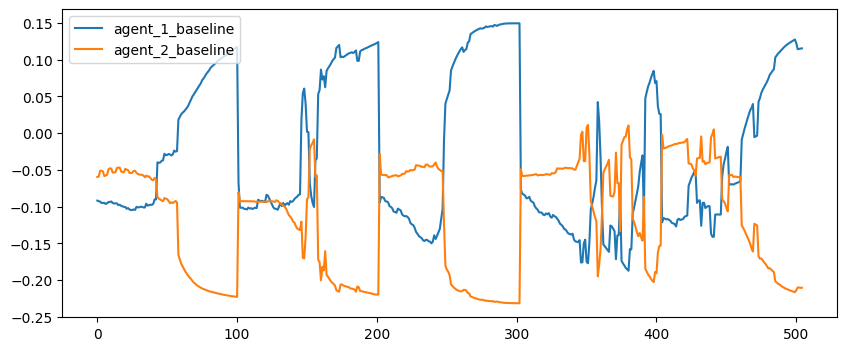

In [9]:
data = {
    'agent_1_baseline': a1_stats.baseline,
    'agent_2_baseline': a2_stats.baseline,   
}

pd.DataFrame(data)[['agent_1_baseline', 'agent_2_baseline']].plot(figsize=(10, 4))